# Halo Bias Calculations

This notebook demonstrates the halo bias calculations available in the `halox` library. We'll explore the Tinker et al. 2010 bias function formalism and its key properties.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from halox import cosmology, bias

jax.config.update("jax_enable_x64", True)

plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

## Setting up the Cosmology

First, let's create a cosmology object using the Planck 2018 parameters provided by halox:

In [2]:
# Create a Planck 2018 cosmology
cosmo = cosmology.Planck18()
print(f"Hubble parameter h = {cosmo.h}")
print(f"Matter density Ω_m = {cosmo.Omega_m}")
print(f"Baryon density Ω_b = {cosmo.Omega_b}")
print(f"Cold dark matter density Ω_c = {cosmo.Omega_c}")
print(f"Power spectrum normalization σ_8 = {cosmo.sigma8}")

Hubble parameter h = 0.6766
Matter density Ω_m = 0.30964
Baryon density Ω_b = 0.04897
Cold dark matter density Ω_c = 0.26067
Power spectrum normalization σ_8 = 0.8102


## Halo Bias Theory

The halo bias quantifies how strongly dark matter halos trace the underlying dark matter density field. The Tinker et al. 2010 formalism expresses the linear halo bias as:

$$b(\nu) = 1 - A \frac{\nu^a}{\nu^a + \delta_{sc}^a} + B \nu^b + C \nu^c$$

where:
- $\nu = \delta_{sc}/\sigma(M,z)$ is the peak height
- $\delta_{sc} = 1.686$ is the spherical collapse threshold
- $\sigma(M,z)$ is the RMS variance of density fluctuations on the mass scale M
- The parameters $A$, $a$, $B$, and $C$ depend on the overdensity threshold:

$$A = 1 + 0.24y \exp\left(-\left(\frac{4}{y}\right)^4\right)$$
$$a = 0.44y - 0.88$$
$$C = 0.019 + 0.107y + 0.19 \exp\left(-\left(\frac{4}{y}\right)^4\right)$$

where $y = \log_{10}(\Delta_{\rm halo})$ and $B = 0.183$, $b = 1.5$, $c = 2.4$ are fixed.

## Basic Bias Calculation

Let's compute the halo bias for a range of halo masses at z=0:

In [3]:
# Mass range from 10^10 to 10^16 h^-1 M_sun
M = jnp.logspace(10, 16, 100)
z = 0.0
delta_c = 200.0

# Compute the halo bias
b = bias.tinker10_bias(M, z, cosmo, delta_c)

print(f"Halo bias computed for {len(M)} mass bins")
print(f"Mass range: {M.min():.2e} to {M.max():.2e} h^-1 M_sun")
print(f"Bias range: {b.min():.3f} to {b.max():.3f}")

Halo bias computed for 100 mass bins
Mass range: 1.00e+10 to 1.00e+16 h^-1 M_sun
Bias range: 0.714 to 30.275


## Bias Visualization

Let's plot the halo bias showing how it increases with halo mass:

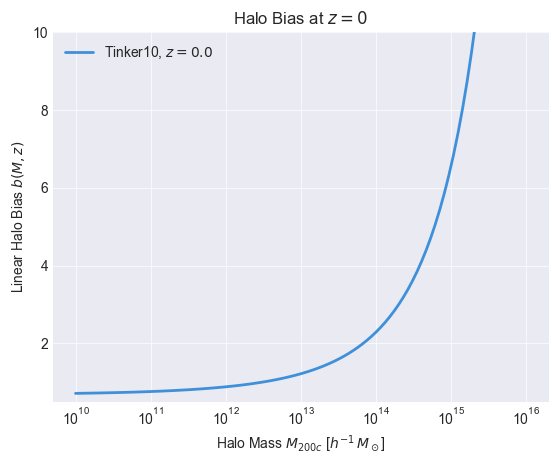

In [4]:
# Plot the halo bias
fig, ax = plt.subplots()
ax.semilogx(M, b, linewidth=2, color="C0", label=f"Tinker10, $z={z:.1f}$")
ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(r"Linear Halo Bias $b(M,z)$")
ax.set_title("Halo Bias at $z=0$")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(0.5, 10)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Redshift Evolution

Now let's examine how the halo bias evolves with redshift:

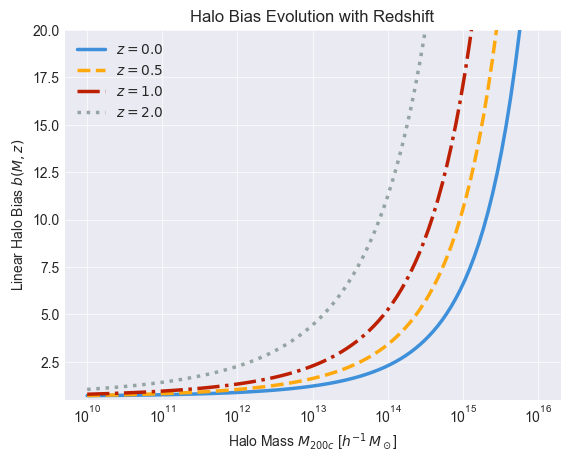

In [5]:
# Different redshifts
redshifts = [0.0, 0.5, 1.0, 2.0]
colors = ["C0", "C1", "C2", "C3"]
linestyles = ["-", "--", "-.", ":"]

fig, ax = plt.subplots()

for z_val, color, ls in zip(redshifts, colors, linestyles):
    b_z = bias.tinker10_bias(M, z_val, cosmo, delta_c)
    ax.semilogx(
        M,
        b_z,
        linewidth=2.5,
        color=color,
        linestyle=ls,
        label=f"$z = {z_val:.1f}$",
    )

ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(r"Linear Halo Bias $b(M,z)$")
ax.set_title("Halo Bias Evolution with Redshift")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(0.5, 20)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Different Cosmologies

Let's compare the halo bias for different cosmological parameters. We'll vary the matter density and power spectrum normalization:

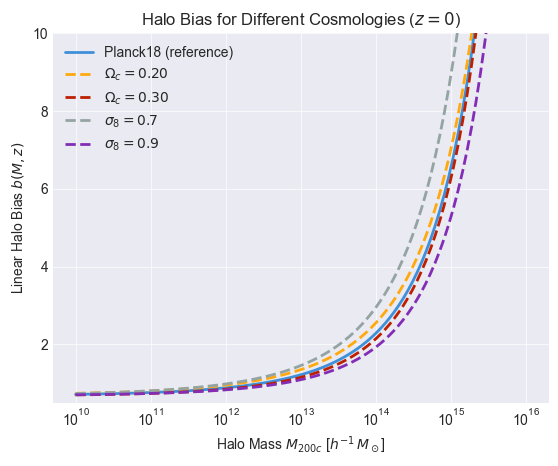

In [ ]:
# Create different cosmologies by modifying Planck18 parameters
cosmo_low_Om = cosmology.Planck18(Omega_c=0.20)
cosmo_high_Om = cosmology.Planck18(Omega_c=0.30)
cosmo_low_s8 = cosmology.Planck18(sigma8=0.7)
cosmo_high_s8 = cosmology.Planck18(sigma8=0.9)

cosmologies = [cosmo_low_Om, cosmo_high_Om, cosmo_low_s8, cosmo_high_s8]
labels = [
    r"$\Omega_c = 0.20$",
    r"$\Omega_c = 0.30$",
    r"$\sigma_8 = 0.7$",
    r"$\sigma_8 = 0.9$",
]
colors = ["C1", "C2", "C3", "C4"]

fig, ax = plt.subplots()

# Plot reference Planck18 cosmology
b_ref = bias.tinker10_bias(M, z, cosmo, delta_c)
ax.semilogx(
    M,
    b_ref,
    linewidth=2,
    color="C0",
    label="Planck18 (reference)",
    linestyle="-",
)

# Plot different cosmologies
for _, (cosmo_test, label, color) in enumerate(
    zip(cosmologies, labels, colors)
):
    b_test = bias.tinker10_bias(M, z, cosmo_test, delta_c)
    ax.semilogx(
        M, b_test, linewidth=2, color=color, label=label, linestyle="--"
    )

ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(r"Linear Halo Bias $b(M,z)$")
ax.set_title("Halo Bias for Different Cosmologies ($z=0$)")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(0.5, 10)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Different Overdensity Definitions

The Tinker10 formalism supports different overdensity definitions. Let's compare Δ = 200c and Δ = 500c:

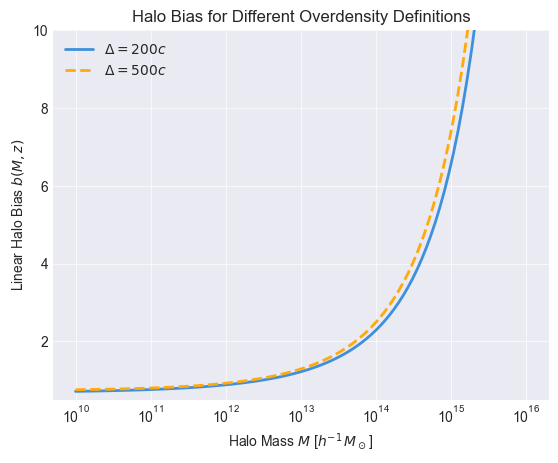

In [7]:
# Different overdensity thresholds
deltas = [200.0, 500.0]
colors = ["C0", "C1"]
linestyles = ["-", "--"]

fig, ax = plt.subplots()

z = 0.0
for delta, color, ls in zip(deltas, colors, linestyles):
    b_delta = bias.tinker10_bias(M, z, cosmo, delta)
    ax.semilogx(
        M,
        b_delta,
        linewidth=2,
        color=color,
        linestyle=ls,
        label=f"$\\Delta = {delta:.0f}c$",
    )

ax.set_xlabel(r"Halo Mass $M$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(r"Linear Halo Bias $b(M,z)$")
ax.set_title("Halo Bias for Different Overdensity Definitions")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(0.5, 10)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Vectorization

The bias functions support vectorized operations, allowing efficient computation for multiple masses and redshifts:

Computed bias for 50 masses and 5 redshifts
Result shape: (5, 50)


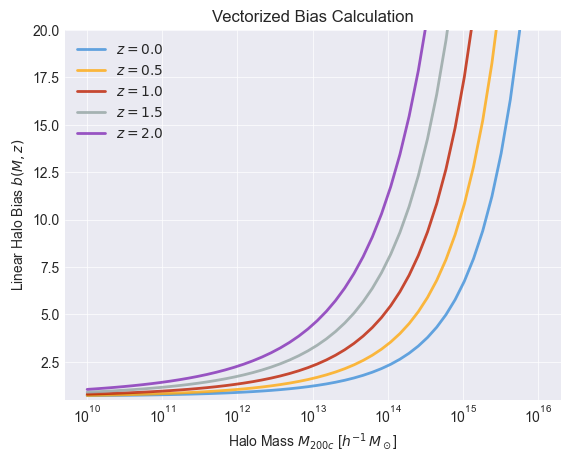

In [8]:
# Vectorized computation for multiple redshifts
M_vec = jnp.logspace(10, 16, 50)  # Smaller mass range for clarity
z_vec = jnp.array([0.0, 0.5, 1.0, 1.5, 2.0])

# Use vmap to vectorize over redshift
b_vec = jax.vmap(bias.tinker10_bias, in_axes=[None, 0, None, None])(
    M_vec, z_vec, cosmo, delta_c
)

print(f"Computed bias for {len(M_vec)} masses and {len(z_vec)} redshifts")
print(f"Result shape: {b_vec.shape}")

# Plot the results
fig, ax = plt.subplots()

for i, z_val in enumerate(z_vec):
    ax.semilogx(
        M_vec,
        b_vec[i],
        linewidth=2,
        label=f"$z = {z_val:.1f}$",
        alpha=0.8,
    )

ax.set_xlabel(r"Halo Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax.set_ylabel(r"Linear Halo Bias $b(M,z)$")
ax.set_title("Vectorized Bias Calculation")
ax.set_xlim(5e9, 2e16)
ax.set_ylim(0.5, 20)
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Bias as a Function of Peak Height

The Tinker10 bias function is often expressed in terms of the peak height $\nu = \delta_{sc}/\sigma(M,z)$. Let's visualize this relationship:

In [ ]:
from halox import lss

# Calculate peak height for different masses at z=0
M_nu = jnp.logspace(10.5, 16.5, 100)
z_nu = 0.0
delta_sc = 1.686

# Calculate sigma(M,z) and peak height
sigma = lss.sigma_M(M_nu, z_nu, cosmo)
nu = delta_sc / sigma

# Calculate bias
b_nu = bias.tinker10_bias(M_nu, z_nu, cosmo, delta_c)

print(f"Peak height range: {nu.min():.3f} to {nu.max():.3f}")
print(f"Bias range: {b_nu.min():.3f} to {b_nu.max():.3f}")

# Plot bias vs peak height
fig, ax = plt.subplots()

ax.loglog(nu, b_nu, linewidth=2, color="C0")
ax.set_xlabel(r"Peak Height $\nu = \delta_{sc}/\sigma(M,z)$")
ax.set_ylabel(r"Linear Halo Bias $b(\nu)$")
ax.set_title("Bias vs Peak Height")
# ax.set_xlim(0.3, 5)
# ax.set_ylim(0.5, 20)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Performance: JIT Compilation

Let's compare the performance with and without JIT compilation:

In [10]:
# Setup for timing
M_timing = jnp.logspace(10, 16, 100)
z_timing = 0.0


def compute_bias(M, z, cosmo=cosmo, delta_c=200.0):
    return bias.tinker10_bias(M, z, cosmo, delta_c)

Without JIT compilation:

In [11]:
%timeit _ = compute_bias(M_timing, z_timing)

529 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With JIT:

In [12]:
compute_bias_j = jax.jit(compute_bias)
_ = compute_bias_j(M_timing, z_timing)
%timeit _ = compute_bias_j(M_timing, z_timing)

2.55 ms ± 20.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
